# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

## Camera Calibration

In [2]:
#reading in a group of images

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print("Image size is wrong in image number:", idx)


Image size is wrong in image number: 4
Image size is wrong in image number: 8


In [3]:
# Camera calibration given object points and image points
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)


## Functions Section

In [4]:
###Functions###
def sobelOperator(img, orient='x', thresh=(20, 100)):
    
    axis = (1,0) if (orient == 'x') else (0,1);
    
    gray =  cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, axis[0],axis[1])
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


def sobelMagnitud(img, sobel_kernel=7, thresh=(20, 100)):
        
    gray =  cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelxM = np.square(sobelx)
    sobelyM = np.square(sobely)
    sobelM = np.sqrt(sobelxM+sobelyM)
    
    abs_sobel = np.absolute(sobelM)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def sobelAngle(img, sobel_kernel=15, thresh=(0.6, 1.3)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    ang_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(ang_sobel)
    binary_output[ (ang_sobel >= thresh[0]) & (ang_sobel <= thresh[1])  ] = 1
    
    return binary_output

#Function to convert RGB image to HLS
def imageThreshold(img, thresh=(90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def slidingWindow(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped, axis=0)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_base = np.argmax(histogram[300:500]) + 300
    rightx_base = np.argmax(histogram[850:1150]) + 850
    
    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return [ploty,left_fitx,right_fitx]

def imageThresholdR(img, thresh=(210, 255)):
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    y = img[:,:,0]
    u = img[:,:,1]
    v = img[:,:,2]
    
    binary = np.zeros_like(y)
    binary[(y > thresh[0]) & (y <= thresh[1])] = 1
    
    return binary

def imageConvert(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    #white_2 = np.zeros_like(S)
    #white_2[(S > 110) & (S <= 255)] = 1
    white_2 = cv2.inRange(HLS, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    
    white_3 = cv2.inRange(img, (200,200,2200), (255,255,255))

    bit_layer = np.zeros_like(yellow)
    newImg = bit_layer | yellow | white | white_2 | white_3
    binary = np.zeros_like(newImg)
    binary[(newImg > 0) ] = 1
    
    return binary

def imageConvert2(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    equ = HLS[:,:,2]
    S = cv2.GaussianBlur(equ,(7,7),0)
    white_2 = np.zeros_like(S)
    white_2[(S > 110) & (S <= 255)] = 1
    #white_2 = cv2.inRange(HLS, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    
    white_3 = cv2.inRange(img, (200,200,2200), (255,255,255))

    bit_layer = np.zeros_like(yellow)
    newImg = bit_layer | yellow | white | white_2 | white_3
    binary = np.zeros_like(newImg)
    binary[(newImg > 0) ] = 1
    
    return binary

## Testing an Image

In [5]:
%matplotlib inline
img = mpimg.imread('test_images/test1.jpg')
image = cv2.undistort(img, mtx, dist, None, mtx)

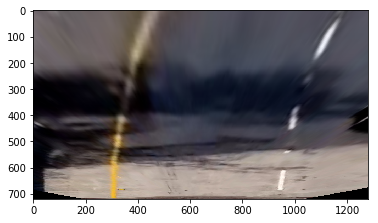

In [24]:
#Perspective transformation
%matplotlib inline

sp1 = [537,490]
sp2 = [197,720]
sp3 = [1090,720]
sp4 = [750,490]

sp1 = [585,460]
sp2 = [235,720]
sp3 = [1080,720]
sp4 = [698,460]

sp1 = [600,450]
sp2 = [235,720]
sp3 = [1075,720]
sp4 = [680,450]

dp1 = [350,0]
dp2 = [350,720]
dp3 = [900,720]
dp4 = [900,0]

p1 = (300,0)
p2 = (300,720)
p3 = (1100,720)
p4 = (1100,0)

src = np.array([sp1,sp2,sp3,sp4],np.float32)
dst = np.array([dp1,dp2,dp3,dp4],np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)

mask = np.zeros_like(warped) 
ignore_mask_color = 255
vertices = np.array([[p1,p2,p3,p4]], dtype=np.int32) 
cv2.fillPoly(mask, vertices, ignore_mask_color)
binary_warped = cv2.bitwise_and(warped, mask)


#binary_warped = cv2.GaussianBlur(binary,(7,7),0)

plt.imshow(warped,cmap='gray')

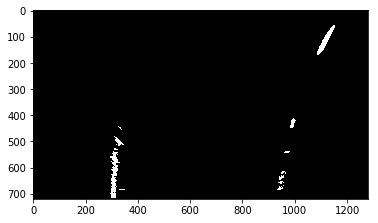

In [25]:
#Obtaining the gradient in X and Y

gradx = sobelOperator(warped, orient='x', thresh=(30, 100))
grady = sobelOperator(warped, orient='y', thresh=(30, 100))

#Obtaining Magnitud and Angle of the gradient 
mag = sobelMagnitud(warped, sobel_kernel=7, thresh=(20, 100))
ang = sobelAngle(warped, sobel_kernel=15, thresh=(0.6, 1.3))

#Obtaining S channel from HLS image
#sChannel = imageThreshold(image)
#rChannel = imageThresholdR(image)
#Combined  Thresholds
#color_binary = np.dstack(( np.zeros_like(gradx), 255*gradx, 255*sChannel))
    
# Combine the two binary thresholds
#combined_binary = np.zeros_like(gradx)
#combined_binary[(sChannel == 1) | (gradx == 1)] = 1
#combined_binary[(sChannel == 1) | (gradx == 1) | (rChannel == 1)] = 1

channel = imageConvert(warped)
binary_warped  = np.zeros_like(gradx)
binary_warped [(channel == 1) | (gradx == 1)] = 1
plt.imshow(channel,cmap='gray')

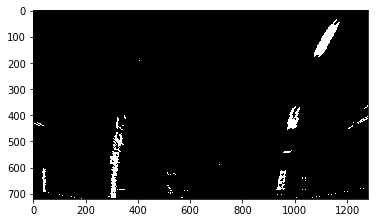

In [26]:
plt.imshow(binary_warped ,cmap='gray')

In [27]:
#Polynomial fitting
[ploty,left_fitx,right_fitx] = slidingWindow(binary_warped)

In [28]:
#Measuring Curvature
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)/2
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

473.508295127 m 583.199461659 m


In [29]:
#Measuring distance from center
maxRX = np.max(right_fitx)
minRX = np.min(right_fitx)

maxLX = np.max(left_fitx)
minLX = np.min(left_fitx)

centerR = (maxRX + minRX)/2.0
centerL = (maxLX + minLX)/2.0

center = 0.5*binary_warped.shape[1] -  (centerL + centerR)/2

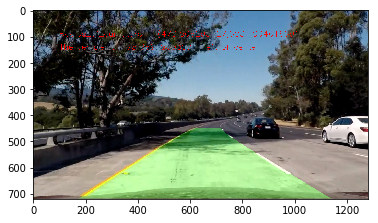

In [30]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

plt.imshow(result)

## Test on Videos

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = 0    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = 0 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.pts_old = None

In [15]:
listLeft = []
listRight = []
leftLine = Line()
rightLine = Line()
points = Line()



In [31]:

def process_image(img):
    image = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Perspective transformation
    src = np.array([sp1,sp2,sp3,sp4],np.float32)
    dst = np.array([dp1,dp2,dp3,dp4],np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    
    #Obtaining the gradient in X and Y

    gradx = sobelOperator(warped, orient='x', thresh=(30, 100))
    grady = sobelOperator(warped, orient='y', thresh=(30, 100))

    #Obtaining Magnitud and Angle of the gradient 
    mag = sobelMagnitud(warped, sobel_kernel=7, thresh=(20, 100))
    ang = sobelAngle(warped, sobel_kernel=15, thresh=(0.6, 1.3))

    channel = imageConvert(warped)
    binary_warped  = np.zeros_like(gradx)
    binary_warped [(channel == 1) | (gradx == 1)] = 1
  
    
    #Polynomial fitting
    [ploty,left_fitx,right_fitx] = slidingWindow(binary_warped)
    
    #Measuring Curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)/2
    
    #Measuring distance from center
    maxRX = np.max(right_fitx)
    minRX = np.min(right_fitx)

    maxLX = np.max(left_fitx)
    minLX = np.min(left_fitx)

    centerR = (maxRX + minRX)/2.0
    centerL = (maxLX + minLX)/2.0

    center = 0.5*binary_warped.shape[1] -  (centerL + centerR)/2
    center =  center*xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])   
    
    
    
    
    
    ###################################################
    
    if (len(left_fitx) < 1 | len(right_fitx) < 1):
        print("##################################")
        print(len(left_fitx))
        print(len(right_fitx))
    
    if (len(leftLine.recent_xfitted) < 4):
        leftLine.recent_xfitted.append(left_fitx)
        rightLine.recent_xfitted.append(right_fitx)
    else:
        del leftLine.recent_xfitted[0]
        del rightLine.recent_xfitted[0]
        leftLine.recent_xfitted.append(left_fitx)
        rightLine.recent_xfitted.append(right_fitx)
    #print (len(leftLine.recent_xfitted))   
    
    for i in range(len(leftLine.recent_xfitted)):
        leftLine.bestx = leftLine.bestx + leftLine.recent_xfitted[i]
        rightLine.bestx = rightLine.bestx + rightLine.recent_xfitted[i]
        
    leftLine.bestx = leftLine.bestx/len(leftLine.recent_xfitted)
    rightLine.bestx = rightLine.bestx//len(leftLine.recent_xfitted)

    #left_fitx = leftLine.bestx
    #right_fitx = rightLine.bestx
    
    
       
    leftLine.current_fit = left_fitx
    rightLine.current_fit = right_fitx
    
    leftLine.best_fit = (left_fit_cr  + leftLine.best_fit)/len(leftLine.recent_xfitted)
    rightLine.best_fit = (right_fit_cr + rightLine.best_fit)/len(leftLine.recent_xfitted)
    
    leftLine.radius_of_curvature = left_curverad
    rightLine.radius_of_curvature = right_curverad 
    
    
    ####################################################
     
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    polygon1 = np.zeros_like(warped).astype(np.uint8)
    polygon2 = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
   

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    #cv2.putText(result,"Radius_of_curvature = (" + str(left_curverad) + "," + str(right_curverad) +")", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    #cv2.putText(result,"The vehicle is " + str(center) + "m left of center", (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    
    cv2.putText(result,"Radius_of_curvature = (" + str(round(left_curverad,2)) + "," + str(round(right_curverad,2)) +")", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    cv2.putText(result,"The vehicle is " + str(round(center,2)) + "m left of center", (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    return result

In [ ]:
white_output = 'project_video.mp4'
clip1 = VideoFileClip("project_video2.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video.mp4
[MoviePy] Writing video project_video.mp4


 36%|███▌      | 454/1261 [03:09<07:34,  1.77it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))